In [ ]:
import torch
import torchvision
from torchvision.datasets import STL10
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import torch.optim as optim
import cv2

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.metrics import classification_report
import seaborn as sns
import os
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


# 2. [400 Level and 700 Level]
# Download Tiny ImageNet dataset from here. Finetune Densenet 121 [20 Marks for Densenet code and data I/O] with the following.

In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 152.9 MB 22 kB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
device = xm.xla_device()

In [ ]:
device

device(type='xla', index=1)

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-04-11 04:52:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  55.9MB/s    in 6.4s    

2022-04-11 04:52:10 (36.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip tiny-imagenet-200.zip;

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
train_dir="/content/tiny-imagenet-200/train"

In [ ]:
os.listdir(train_dir)[1:10]

['n02795169',
 'n03388043',
 'n03980874',
 'n02909870',
 'n02815834',
 'n02415577',
 'n02395406',
 'n02410509',
 'n01882714']

In [ ]:
class DENSENET_FINETUNE(nn.Module):
    def __init__(self,num_classes):
        super(DENSENET_FINETUNE,self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        for param in self.model.parameters():
          param.requires_grad=False
        self.model.features.denseblock4.denselayer14.requires_grad_=True  
        self.model.features.denseblock4.denselayer15.requires_grad_=True
        self.model.features.denseblock4.denselayer16.requires_grad_=True
        self.model.features.norm5.requires_grad_=True
        self.model.classifier.requires_grad=True
        self.model.classifier = nn.Linear(1024, num_classes)
    def forward(self,x):
        out=self.model(x)
        return out

In [ ]:
model=DENSENET_FINETUNE(200)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
for p in model.parameters():
  if p.requires_grad==True:
    print(p.shape)

torch.Size([200, 1024])
torch.Size([200])


In [ ]:
y=model(torch.randn(10,3,225,225))

In [ ]:
y.shape

torch.Size([10, 200])

In [ ]:
y

tensor([[-1.4915e-01, -8.4906e-01,  9.2537e-02,  ..., -2.9352e-01,
         -9.9553e-02, -2.0546e-01],
        [-6.0908e-02, -7.2044e-01,  3.2383e-01,  ...,  7.1821e-04,
         -1.0425e-01,  2.2606e-02],
        [-2.3862e-01, -8.0308e-01, -2.4946e-01,  ..., -3.1320e-02,
          7.6869e-03,  5.0354e-01],
        ...,
        [-3.0308e-01, -8.4992e-01,  4.6610e-01,  ..., -1.8963e-01,
         -6.7976e-01,  5.4898e-01],
        [-8.6134e-02, -5.9929e-01, -4.8090e-02,  ...,  7.9902e-02,
         -4.6149e-01, -2.4060e-02],
        [ 4.1914e-02, -1.0352e+00,  6.6737e-03,  ..., -4.0230e-01,
         -2.1770e-01,  6.8768e-02]], grad_fn=<AddmmBackward0>)

In [ ]:
train_dir="/content/tiny-imagenet-200/train/"
classes=os.listdir(train_dir)
images=[]
labels=[]
for i in range(len(classes)):
    cur_dir=train_dir+classes[i]+"/images/"
    for img_path in os.listdir(cur_dir):
        cur_img=cur_dir+img_path
        images.append(cur_img)
        labels.append(i)

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images_name,labels_name,transform=None):
        self.images_name=images_name
        self.transform=transform
        self.labels_name=labels_name
    def __len__(self):
        return len(self.images_name)
    def __getitem__(self,i):
        path=self.images_name[i]
        img=Image.open(path)
        img = img.convert('RGB')
        img_transform=self.transform(img)
        return img_transform,int(self.labels_name[i])

In [ ]:
train_data=Dataset(images,labels,transform)

In [ ]:
bs=5000
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
train_data[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
file=open(test_annotations,"r+")
data=file.readlines()

In [ ]:
test_classes=[]
images_names=[]
for i in data:
  w=i.split("\t")
  images_names.append(w[0])
  test_classes.append(classes.index(w[1]))

In [ ]:
test_dir="/content/tiny-imagenet-200/val/images/"
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
test_images=[]
test_labels=[]
for i in range(len(images_names)):
    cur_dir=test_dir+images_names[i]
    test_images.append(cur_dir)

In [ ]:
test_data=Dataset(test_images,test_classes,transform)

In [ ]:
bs=5000
test_loader=DataLoader(dataset=test_data,batch_size=bs,shuffle=True,num_workers=8)

# a. Triplet Loss as the final classification loss function [20 marks]

In [ ]:
train_dir="/content/tiny-imagenet-200/train/"
classes=os.listdir(train_dir)
images=[]
labels=[]
for i in range(len(classes)):
    class_data=[]
    class_labels=[]
    cur_dir=train_dir+classes[i]+"/images/"
    for img_path in os.listdir(cur_dir):
        cur_img=cur_dir+img_path
        class_data.append(cur_img)
        class_labels.append(i)
    images.append(class_data)
    labels.append(class_labels)

In [ ]:
import random
class Dataset_t(torch.utils.data.Dataset):
    def __init__(self,images_name,labels_name,transform=None):
        self.images_name=images_name
        self.transform=transform
        self.labels_name=labels_name
        self.class_name=0

    def __len__(self):
        return 50000

    def __getitem__(self,i):

        class_name=self.class_name

        [anchor_path,positive_path]=random.sample(self.images_name[self.class_name],2)
        negative_classes=[x for x in range(0,200) if x != self.class_name]
        negative_class=random.sample(negative_classes,1)[0]

        negative_path=random.sample(self.images_name[negative_class],1)[0]

        anchor_img=Image.open(anchor_path)
        anchor_img = anchor_img.convert('RGB')
        anchor_img_transform=self.transform(anchor_img)

        negative_img=Image.open(negative_path)
        negative_img = negative_img.convert('RGB')
        negative_img_transform=self.transform(negative_img)

        positive_img=Image.open(positive_path)
        positive_img = positive_img.convert('RGB')
        positive_img_transform=self.transform(positive_img)

        self.class_name+=1
        if self.class_name>199:
          self.class_name=0

        return (anchor_img_transform,positive_img_transform,negative_img_transform) #class_name,class_name,negative_class)

In [ ]:
bs=1666
train_data=Dataset_t(images,labels,transform)
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=3)

In [ ]:
model=DENSENET_FINETUNE(200).to(device)
optimizer=optim.Adam(params=model.parameters(),lr=0.001)
criterion=nn.TripletMarginLoss(margin=1.0, p=2)

epochs=1
for epoch in range(epochs):
    batch=0
    for (anchor_img, positive_img, negative_img) in train_loader:
        anchor_img, positive_img, negative_img=anchor_img.to(device),positive_img.to(device),negative_img.to(device)

        anchor_out=model(anchor_img)
        positive_out=model(positive_img)
        negative_out=model(negative_img)


        loss=criterion(anchor_out,positive_out,negative_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()

        batch+=1
        if batch==20:
          break
        anchor_img, positive_img, negative_img=anchor_img.detach(),positive_img.detach(),negative_img.detach()
        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 1.589310646057129
Epoch: 1 Batch: 2 Training Loss: 1.5475014448165894
Epoch: 1 Batch: 3 Training Loss: 1.4598686695098877


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 4 Training Loss: 1.4729645252227783


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 5 Training Loss: 1.4227337837219238


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 6 Training Loss: 1.321283221244812
Epoch: 1 Batch: 7 Training Loss: 1.3154962062835693
Epoch: 1 Batch: 8 Training Loss: 1.324608564376831
Epoch: 1 Batch: 9 Training Loss: 1.1961135864257812
Epoch: 1 Batch: 10 Training Loss: 1.2108961343765259
Epoch: 1 Batch: 11 Training Loss: 1.1806421279907227
Epoch: 1 Batch: 12 Training Loss: 1.1403021812438965
Epoch: 1 Batch: 13 Training Loss: 1.0612798929214478
Epoch: 1 Batch: 14 Training Loss: 1.1092277765274048
Epoch: 1 Batch: 15 Training Loss: 1.0561844110488892
Epoch: 1 Batch: 16 Training Loss: 1.0643956661224365
Epoch: 1 Batch: 17 Training Loss: 1.0471324920654297
Epoch: 1 Batch: 18 Training Loss: 1.006978154182434
Epoch: 1 Batch: 19 Training Loss: 0.9959336519241333


In [ ]:
torch.save(model.state_dict(), 'tripleloss_checkpoint.pth')

# b. Cross-Entropy as the final classification loss function [10 marks]

In [ ]:
#device="cuda"
model=DENSENET_FINETUNE(200).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion=nn.CrossEntropyLoss()

epochs=1
for epoch in range(epochs):
    batch=0
    for image,label in train_loader:
        image,label=image.to(device),label.to(device)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
        batch+=1
        image,label=image.detach(),label.detach()
        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 5.594775676727295
Epoch: 1 Batch: 2 Training Loss: 5.423710346221924
Epoch: 1 Batch: 3 Training Loss: 5.350572109222412
Epoch: 1 Batch: 4 Training Loss: 5.24753999710083
Epoch: 1 Batch: 5 Training Loss: 5.157971382141113
Epoch: 1 Batch: 6 Training Loss: 5.063900470733643
Epoch: 1 Batch: 7 Training Loss: 4.968999862670898
Epoch: 1 Batch: 8 Training Loss: 4.909599304199219
Epoch: 1 Batch: 9 Training Loss: 4.8304924964904785
Epoch: 1 Batch: 10 Training Loss: 4.693960666656494
Epoch: 1 Batch: 11 Training Loss: 4.632184982299805
Epoch: 1 Batch: 12 Training Loss: 4.538096904754639
Epoch: 1 Batch: 13 Training Loss: 4.488636016845703
Epoch: 1 Batch: 14 Training Loss: 4.431417942047119
Epoch: 1 Batch: 15 Training Loss: 4.338597297668457
Epoch: 1 Batch: 16 Training Loss: 4.268797874450684
Epoch: 1 Batch: 17 Training Loss: 4.235251426696777
Epoch: 1 Batch: 18 Training Loss: 4.165388107299805
Epoch: 1 Batch: 19 Training Loss: 4.083281993865967
Epoch: 1 Batch: 20 Tr

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
model.eval()

DENSENET_FINETUNE(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [ ]:
def test_accuarcy(model,test_loader):
    accuracy=0.0
    total=0.0
    with torch.no_grad():
      for image,label in test_loader:
          image=image.to(device)
          out=model(image)
          acc = ((out.argmax(dim=1) == label).float().sum())
          tot=len(test_loader)
          accuracy+=acc
          total+=len(image)
    print("Accuracy on Testing dataset:",accuracy/total)

In [ ]:
test_accuarcy(model,test_loader)

Accuracy on Testing dataset: tensor(0.2200)


# c. Center loss as the final classification loss function [20 marks]

In [ ]:
def compute_center_loss(features, centers, targets):
    features = features.view(features.size(0), -1)
    target_centers = centers[targets]
    criterion = torch.nn.MSELoss()
    center_loss = criterion(features, target_centers)
    return center_loss

In [ ]:
bs=1000
train_data=Dataset(images,labels,transform)
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
#device="cuda"
model=DENSENET_FINETUNE(200).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion=torch.nn.MSELoss()

centers=[torch.zeros(200) for i in range(200)]
number=[0 for i in range(200)]

epochs=1
for epoch in range(epochs):
    batch=0
    for image,label in train_loader:

        for i in label:
          number[int(i)]+=1.0

        image=image.to(device)
        out=model(image)

        center_loss=0
        for i in range(len(label)):
          target_centers = centers[int(label[i])]
          center_loss += criterion(out, target_centers)
      
        optimizer.zero_grad()
        center_loss.backward(retain_graph=True)
        optimizer.step()

        l=center_loss.item()

        for i in range(len(label)):
          centers[label[i]]=centers[label[i]]+(1/number[label[i]])*(out[i]-centers[label[i]])

        batch+=1
        image=image.detach()

        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 536.0440063476562
Epoch: 1 Batch: 2 Training Loss: 557.6414184570312
Epoch: 1 Batch: 3 Training Loss: 514.5760498046875
Epoch: 1 Batch: 4 Training Loss: 474.3051452636719
Epoch: 1 Batch: 5 Training Loss: 440.8599548339844
Epoch: 1 Batch: 6 Training Loss: 406.16827392578125
Epoch: 1 Batch: 7 Training Loss: 376.3351135253906
Epoch: 1 Batch: 8 Training Loss: 348.0061950683594
Epoch: 1 Batch: 9 Training Loss: 322.1061096191406
Epoch: 1 Batch: 10 Training Loss: 301.707275390625
Epoch: 1 Batch: 11 Training Loss: 283.8541564941406
Epoch: 1 Batch: 12 Training Loss: 266.03350830078125
Epoch: 1 Batch: 13 Training Loss: 248.57452392578125
Epoch: 1 Batch: 14 Training Loss: 234.8320770263672
Epoch: 1 Batch: 15 Training Loss: 223.99217224121094
Epoch: 1 Batch: 16 Training Loss: 211.7350311279297
Epoch: 1 Batch: 17 Training Loss: 200.9176788330078
Epoch: 1 Batch: 18 Training Loss: 190.6800537109375
Epoch: 1 Batch: 19 Training Loss: 180.57943725585938
Epoch: 1 Batch: 2

In [ ]:
torch.save(model.state_dict(), 'center_loss_checkpoint.pth')

# Choose any evaluation metrics (at least 3) and compare the models in a, b and c, comment on which one is better and why? [5+5+5+15 = 30 marks]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
test_classes=[]
images_names=[]
for i in data:
  w=i.split("\t")
  images_names.append(w[0])
  test_classes.append(classes.index(w[1]))

test_dir="/content/tiny-imagenet-200/val/images/"
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
test_images=[]
test_labels=[]
for i in range(len(images_names)):
    cur_dir=test_dir+images_names[i]
    test_images.append(cur_dir)

In [ ]:
triplet_loss_model=torch.load("/content/tripleloss_checkpoint.pth")
center_loss_model=torch.load("/content/center_loss_checkpoint.pth")
cross_entropy_model=torch.load("/content/crossentropy_checkpoint.pth")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(triplet_loss_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [ ]:
model.eval();

In [ ]:
y=model(torch.randn(10,3,225,225))

In [ ]:
bs=5000
test_data=Dataset(test_images,test_classes,transform)
test_loader=DataLoader(dataset=test_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

In [ ]:
output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

In [ ]:
output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)

Text(0.5, 1.0, "Triplet Loss's embeddings's PCA")

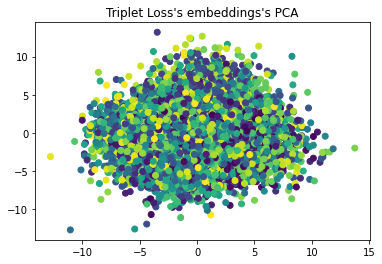

In [ ]:
plt.scatter(pca_out[:,0],pca_out[:,1],c=output_labels_final)
plt.title("Triplet Loss's embeddings's PCA")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(center_loss_model)
model.eval()

model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Text(0.5, 1.0, "Center Loss's embeddings's PCA")

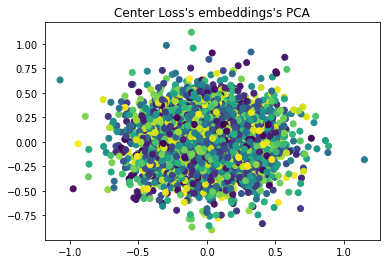

In [ ]:
plt.scatter(pca_out[:,0],pca_out[:,1],c=output_labels_final)
plt.title("Center Loss's embeddings's PCA")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(cross_entropy_model)
model.eval()

model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)

